<a href="https://colab.research.google.com/github/FokaKefir/KepKreator/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependecies

In [1]:
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, Input, Flatten, Reshape, Embedding, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt

import sys, os

# Preprocess the data

## Load data

In [11]:
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

## Plot some random examples

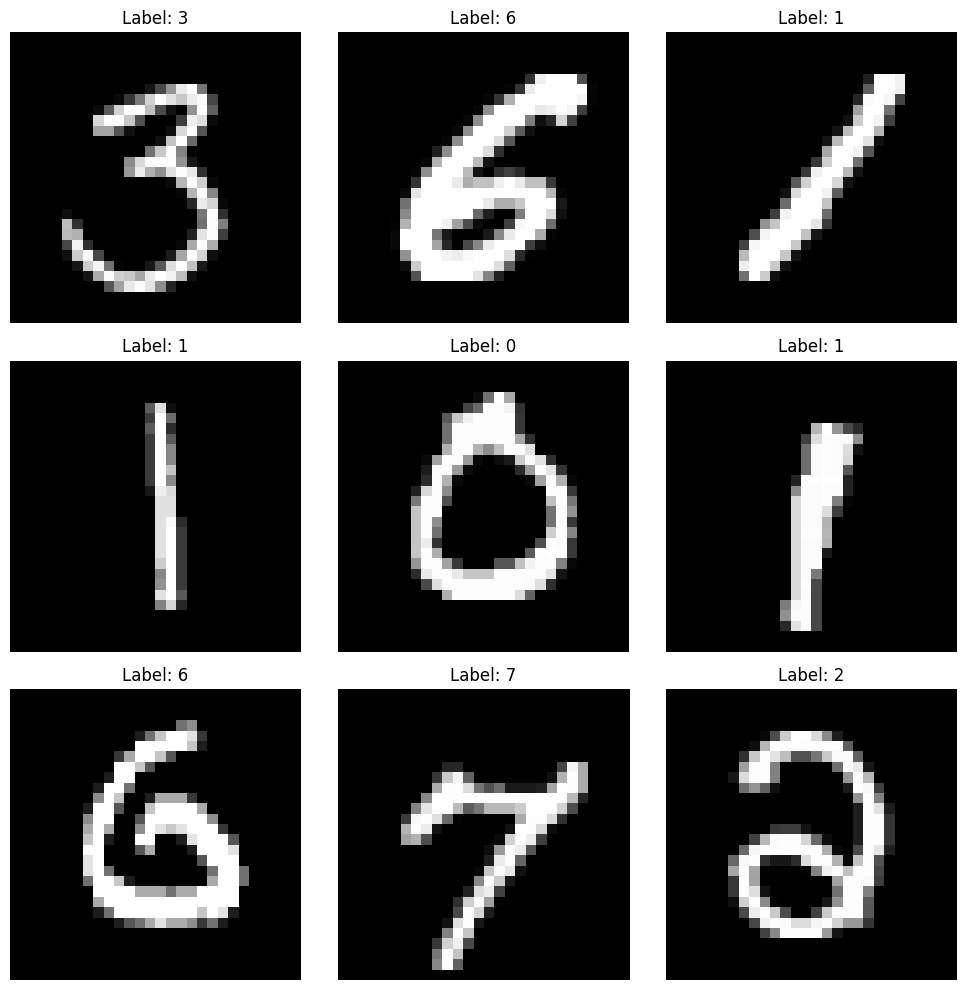

In [13]:
def show_images(examples):
  random_indices = np.random.choice(examples.shape[0], 9, replace=False)

  # rescale images (-1, +1) -> (0, 1)
  examples = 0.5 * examples + 0.5

  plt.figure(figsize=(10, 10))
  for i, index in enumerate(random_indices, 1):
      plt.subplot(3, 3, i)
      plt.imshow(x_train[index], cmap='gray')
      plt.title(f"Label: {labels_train[index]}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

show_images(x_train)

# Define the Model

## Define Discriminator

In [4]:
def build_discriminator(in_shape=(28, 28, 1), n_classes=10):

  # label input
  i_label = Input(shape=(1, ))
  x_label = Embedding(n_classes, 50)(i_label)
  x_label = Dense(in_shape[0] * in_shape[1], activation='tanh')(x_label)
  x_label = Reshape((in_shape[0], in_shape[1], 1))(x_label)

  # image input
  i_img = Input(shape=in_shape)

  # concatenate
  x = Concatenate()([x_label, i_img])

  # conv layers
  x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='tanh')(i_img)
  x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='tanh')(x)
  x = Flatten()(x)
  x = Dense(128, activation='tanh')(x)
  x = Dropout(0.5)(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model([i_img, i_label], x)
  model.compile(
      loss='binary_crossentropy',
      optimizer=Adam(0.0002, beta_1=0.5),
      metrics=['accuracy']
  )
  return model


## Define Generator

In [26]:
def build_generator(latent_dim, n_classes=10):

  # label input
  i_label = Input(shape=(1, ))
  x_label = Embedding(n_classes, 50)(i_label)
  x_label = Dense(7 * 7 * 28, activation='tanh')(x_label)
  x_label = Reshape((7, 7, 28))(x_label)

  # foundation for 7x7 image
  i_lat = Input(shape=(latent_dim, ))
  x_lat = Dense(100 * 7 * 7, activation='tanh')(i_lat)
  x_lat = Reshape((7, 7, 100))(x_lat)

  # concatenate
  x = Concatenate()([x_lat, x_label])

  # upsample to 14x14
  x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

  # upsample to 28x28
  x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

  # make only one color channel, values in (-1, +1)
  x = Conv2D(1, (7, 7), activation='tanh', padding='same')(x)
  return Model([i_lat, i_label], x)

## Define GAN

In [27]:
def define_gan(generator, discriminator):
  # make weights in the discriminator not trainable
  discriminator.trainable = False

  # get noise and label inputs from generator model
  gen_lat, gen_label = generator.input

  # get image output from the generator model
  gen_output = generator.output

  # connect image output and label input from generator as inputs to discriminator
  gan_output = discriminator([gen_output, gen_label])

  # define gan model as taking noise and label and outputting a classification
  model = Model([gen_lat, gen_label], gan_output)

  model.compile(
      loss='binary_crossentropy',
      optimizer=Adam(learning_rate=0.0002, beta_1=0.5)
  )
  return model

## Real image sampling

In [28]:
def generate_real_samples(dataset, n_samples):
  images, labels = dataset

  ix = np.random.choice(labels.shape[0], n_samples)
  x_imgs = images[ix]
  x_labels = labels[ix]
  y = np.ones((n_samples, 1))
  return [x_imgs, x_labels], y

## Lateint point generator

In [29]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  x_labels = np.random.randint(0, n_classes, n_samples)
  return [x_input, x_labels]

## Fake image generator

In [30]:
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  x_input, x_labels = generate_latent_points(latent_dim, n_samples)

  # predict outputs
  imgs = generator.predict([x_input, x_labels])

  # create class labels
  y = np.zeros((n_samples, 1))
  return [imgs, x_labels], y

# Train the Model

## Fake image sampling

In [31]:
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

def sample_images(generator, latent_dim, epoch=0, batch=0, method='show'):
    data, _ = generate_fake_samples(generator, latent_dim, 25)
    imgs, labels = data
    rows, cols = 5, 5

    # Rescale images (-1, +1) -> (0, 1)
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols, figsize=(9, 10))
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx], cmap='gray')
            axs[i, j].set_title(f'num: {labels[idx]}')
            axs[i, j].axis('off')
            idx += 1

    if method == 'show':
      plt.show()
    elif method == 'save':
      fig.savefig(f'gan_images/sample_e{epoch}_b{batch}.png')
      plt.close()

## Define train function

In [32]:
def train(generator, discriminator, gan, dataset, latent_dim, epochs=100, batch_size=64):
  bat_per_epo = dataset[0].shape[0] // batch_size
  half_batch = batch_size // 2

  # manually enumerate epochs
  for epoch in range(epochs):

    # enumerate batches over the training set
    for b in range(bat_per_epo):

      # get randomly selected 'real' samples, with labels
      x_real, y_real = generate_real_samples(dataset, half_batch)

      # update discriminator model weights
      d_loss_real, d_acc_real = discriminator.train_on_batch(x_real, y_real)

      # generate 'fake' examples, with labels
      x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)

      # update discriminator model weights
      d_loss_fake, d_acc_fake = discriminator.train_on_batch(x_fake, y_fake)

      # calculate loss and accuracy
      d_loss = 0.5 * (d_loss_real + d_loss_fake)
      d_acc = 0.5 * (d_acc_real + d_acc_fake)

      # prepare points in latent space as input for the generator, with
      x_gan = generate_latent_points(latent_dim, batch_size)

      # create inverted labels for the fake samples
      y_gan = np.ones((batch_size, 1))

      # update the generator via the discriminator's error
      g_loss = gan.train_on_batch(x_gan, y_gan)

      # summarize loss on this batch
      print(f'>{epoch + 1}/{epochs}, {b + 1}/{bat_per_epo}, d_loss={d_loss:.3f}, d_acc={d_acc:.3f} g_loss={g_loss:.3f}')

      if (b + 1) % 300 == 0:
        sample_images(generator, latent_dim, epoch + 1, b + 1, method='save')

    generator.save(f'generator_{epoch + 1}.h5')

# Create models and train

In [33]:
# size of the latent space
latent_dim = 100

# create the discriminator
discriminator = build_discriminator()

# create the generator
generator = build_generator(latent_dim)

# create the gan
gan = define_gan(generator, discriminator)

# train
train(
    generator,
    discriminator,
    gan,
    (x_train, labels_train),
    latent_dim,
    epochs=16,
    batch_size=100
)

2/2 [==============================] - 0s 49ms/step
>1/16, 1/600, d_loss=0.637, d_acc=0.620 g_loss=0.691
2/2 [==============================] - 0s 7ms/step
>1/16, 2/600, d_loss=0.449, d_acc=0.670 g_loss=0.691
2/2 [==============================] - 0s 5ms/step
>1/16, 3/600, d_loss=0.394, d_acc=0.650 g_loss=0.688
2/2 [==============================] - 0s 7ms/step
>1/16, 4/600, d_loss=0.381, d_acc=0.610 g_loss=0.684
2/2 [==============================] - 0s 6ms/step
>1/16, 5/600, d_loss=0.374, d_acc=0.640 g_loss=0.680
2/2 [==============================] - 0s 6ms/step
>1/16, 6/600, d_loss=0.373, d_acc=0.620 g_loss=0.664
2/2 [==============================] - 0s 6ms/step
>1/16, 7/600, d_loss=0.379, d_acc=0.580 g_loss=0.663
2/2 [==============================] - 0s 6ms/step
>1/16, 8/600, d_loss=0.391, d_acc=0.540 g_loss=0.653
2/2 [==============================] - 0s 5ms/step
>1/16, 9/600, d_loss=0.399, d_acc=0.520 g_loss=0.636
2/2 [==============================] - 0s 6ms/step
>1/16, 10/60

2/2 [==============================] - 0s 7ms/step
>2/16, 1/600, d_loss=0.708, d_acc=0.470 g_loss=0.734
2/2 [==============================] - 0s 6ms/step
>2/16, 2/600, d_loss=0.714, d_acc=0.460 g_loss=0.716
2/2 [==============================] - 0s 6ms/step
>2/16, 3/600, d_loss=0.713, d_acc=0.400 g_loss=0.713
2/2 [==============================] - 0s 7ms/step
>2/16, 4/600, d_loss=0.701, d_acc=0.460 g_loss=0.747
2/2 [==============================] - 0s 7ms/step
>2/16, 5/600, d_loss=0.694, d_acc=0.450 g_loss=0.751
2/2 [==============================] - 0s 6ms/step
>2/16, 6/600, d_loss=0.702, d_acc=0.500 g_loss=0.740
2/2 [==============================] - 0s 9ms/step
>2/16, 7/600, d_loss=0.692, d_acc=0.540 g_loss=0.739
2/2 [==============================] - 0s 6ms/step
>2/16, 8/600, d_loss=0.688, d_acc=0.560 g_loss=0.750
2/2 [==============================] - 0s 6ms/step
>2/16, 9/600, d_loss=0.691, d_acc=0.560 g_loss=0.735
2/2 [==============================] - 0s 7ms/step
>2/16, 10/600

2/2 [==============================] - 0s 8ms/step
>3/16, 1/600, d_loss=0.702, d_acc=0.500 g_loss=0.712
2/2 [==============================] - 0s 6ms/step
>3/16, 2/600, d_loss=0.698, d_acc=0.520 g_loss=0.713
2/2 [==============================] - 0s 7ms/step
>3/16, 3/600, d_loss=0.705, d_acc=0.480 g_loss=0.721
2/2 [==============================] - 0s 8ms/step
>3/16, 4/600, d_loss=0.698, d_acc=0.450 g_loss=0.715
2/2 [==============================] - 0s 9ms/step
>3/16, 5/600, d_loss=0.700, d_acc=0.460 g_loss=0.714
2/2 [==============================] - 0s 8ms/step
>3/16, 6/600, d_loss=0.701, d_acc=0.490 g_loss=0.716
2/2 [==============================] - 0s 6ms/step
>3/16, 7/600, d_loss=0.697, d_acc=0.500 g_loss=0.709
2/2 [==============================] - 0s 8ms/step
>3/16, 8/600, d_loss=0.703, d_acc=0.470 g_loss=0.717
2/2 [==============================] - 0s 7ms/step
>3/16, 9/600, d_loss=0.710, d_acc=0.450 g_loss=0.706
2/2 [==============================] - 0s 7ms/step
>3/16, 10/600

2/2 [==============================] - 0s 9ms/step
>4/16, 1/600, d_loss=0.698, d_acc=0.490 g_loss=0.728
2/2 [==============================] - 0s 10ms/step
>4/16, 2/600, d_loss=0.693, d_acc=0.560 g_loss=0.734
2/2 [==============================] - 0s 8ms/step
>4/16, 3/600, d_loss=0.678, d_acc=0.550 g_loss=0.725
2/2 [==============================] - 0s 8ms/step
>4/16, 4/600, d_loss=0.691, d_acc=0.520 g_loss=0.721
2/2 [==============================] - 0s 8ms/step
>4/16, 5/600, d_loss=0.685, d_acc=0.560 g_loss=0.727
2/2 [==============================] - 0s 8ms/step
>4/16, 6/600, d_loss=0.697, d_acc=0.520 g_loss=0.732
2/2 [==============================] - 0s 6ms/step
>4/16, 7/600, d_loss=0.690, d_acc=0.490 g_loss=0.726
2/2 [==============================] - 0s 9ms/step
>4/16, 8/600, d_loss=0.697, d_acc=0.540 g_loss=0.734
2/2 [==============================] - 0s 9ms/step
>4/16, 9/600, d_loss=0.692, d_acc=0.580 g_loss=0.727
2/2 [==============================] - 0s 8ms/step
>4/16, 10/60

2/2 [==============================] - 0s 12ms/step
>5/16, 1/600, d_loss=0.681, d_acc=0.600 g_loss=0.733
2/2 [==============================] - 0s 10ms/step
>5/16, 2/600, d_loss=0.679, d_acc=0.650 g_loss=0.722
2/2 [==============================] - 0s 17ms/step
>5/16, 3/600, d_loss=0.710, d_acc=0.410 g_loss=0.707
2/2 [==============================] - 0s 7ms/step
>5/16, 4/600, d_loss=0.696, d_acc=0.490 g_loss=0.701
2/2 [==============================] - 0s 6ms/step
>5/16, 5/600, d_loss=0.689, d_acc=0.520 g_loss=0.685
2/2 [==============================] - 0s 7ms/step
>5/16, 6/600, d_loss=0.724, d_acc=0.410 g_loss=0.680
2/2 [==============================] - 0s 11ms/step
>5/16, 7/600, d_loss=0.702, d_acc=0.480 g_loss=0.683
2/2 [==============================] - 0s 6ms/step
>5/16, 8/600, d_loss=0.704, d_acc=0.440 g_loss=0.689
2/2 [==============================] - 0s 6ms/step
>5/16, 9/600, d_loss=0.696, d_acc=0.500 g_loss=0.690
2/2 [==============================] - 0s 10ms/step
>5/16, 1

2/2 [==============================] - 0s 8ms/step
>6/16, 1/600, d_loss=0.691, d_acc=0.540 g_loss=0.728
2/2 [==============================] - 0s 7ms/step
>6/16, 2/600, d_loss=0.693, d_acc=0.530 g_loss=0.706
2/2 [==============================] - 0s 11ms/step
>6/16, 3/600, d_loss=0.701, d_acc=0.470 g_loss=0.698
2/2 [==============================] - 0s 13ms/step
>6/16, 4/600, d_loss=0.675, d_acc=0.610 g_loss=0.710
2/2 [==============================] - 0s 8ms/step
>6/16, 5/600, d_loss=0.707, d_acc=0.470 g_loss=0.703
2/2 [==============================] - 0s 8ms/step
>6/16, 6/600, d_loss=0.703, d_acc=0.460 g_loss=0.706
2/2 [==============================] - 0s 7ms/step
>6/16, 7/600, d_loss=0.709, d_acc=0.420 g_loss=0.702
2/2 [==============================] - 0s 10ms/step
>6/16, 8/600, d_loss=0.683, d_acc=0.530 g_loss=0.699
2/2 [==============================] - 0s 14ms/step
>6/16, 9/600, d_loss=0.702, d_acc=0.500 g_loss=0.700
2/2 [==============================] - 0s 6ms/step
>6/16, 10

2/2 [==============================] - 0s 12ms/step
>7/16, 1/600, d_loss=0.683, d_acc=0.580 g_loss=0.743
2/2 [==============================] - 0s 11ms/step
>7/16, 2/600, d_loss=0.676, d_acc=0.660 g_loss=0.723
2/2 [==============================] - 0s 13ms/step
>7/16, 3/600, d_loss=0.671, d_acc=0.650 g_loss=0.722
2/2 [==============================] - 0s 7ms/step
>7/16, 4/600, d_loss=0.675, d_acc=0.580 g_loss=0.733
2/2 [==============================] - 0s 9ms/step
>7/16, 5/600, d_loss=0.662, d_acc=0.630 g_loss=0.729
2/2 [==============================] - 0s 6ms/step
>7/16, 6/600, d_loss=0.698, d_acc=0.520 g_loss=0.718
2/2 [==============================] - 0s 8ms/step
>7/16, 7/600, d_loss=0.667, d_acc=0.610 g_loss=0.730
2/2 [==============================] - 0s 11ms/step
>7/16, 8/600, d_loss=0.670, d_acc=0.620 g_loss=0.729
2/2 [==============================] - 0s 8ms/step
>7/16, 9/600, d_loss=0.688, d_acc=0.540 g_loss=0.728
2/2 [==============================] - 0s 6ms/step
>7/16, 10

2/2 [==============================] - 0s 12ms/step
>8/16, 1/600, d_loss=0.690, d_acc=0.530 g_loss=0.741
2/2 [==============================] - 0s 11ms/step
>8/16, 2/600, d_loss=0.631, d_acc=0.700 g_loss=0.714
2/2 [==============================] - 0s 6ms/step
>8/16, 3/600, d_loss=0.743, d_acc=0.400 g_loss=0.739
2/2 [==============================] - 0s 7ms/step
>8/16, 4/600, d_loss=0.707, d_acc=0.550 g_loss=0.688
2/2 [==============================] - 0s 8ms/step
>8/16, 5/600, d_loss=0.710, d_acc=0.490 g_loss=0.702
2/2 [==============================] - 0s 13ms/step
>8/16, 6/600, d_loss=0.695, d_acc=0.530 g_loss=0.733
2/2 [==============================] - 0s 7ms/step
>8/16, 7/600, d_loss=0.681, d_acc=0.500 g_loss=0.744
2/2 [==============================] - 0s 8ms/step
>8/16, 8/600, d_loss=0.715, d_acc=0.520 g_loss=0.716
2/2 [==============================] - 0s 12ms/step
>8/16, 9/600, d_loss=0.731, d_acc=0.470 g_loss=0.736
2/2 [==============================] - 0s 6ms/step
>8/16, 10

2/2 [==============================] - 0s 8ms/step
>9/16, 1/600, d_loss=0.693, d_acc=0.530 g_loss=0.744
2/2 [==============================] - 0s 12ms/step
>9/16, 2/600, d_loss=0.697, d_acc=0.560 g_loss=0.736
2/2 [==============================] - 0s 12ms/step
>9/16, 3/600, d_loss=0.679, d_acc=0.550 g_loss=0.758
2/2 [==============================] - 0s 13ms/step
>9/16, 4/600, d_loss=0.693, d_acc=0.520 g_loss=0.775
2/2 [==============================] - 0s 8ms/step
>9/16, 5/600, d_loss=0.708, d_acc=0.460 g_loss=0.756
2/2 [==============================] - 0s 8ms/step
>9/16, 6/600, d_loss=0.704, d_acc=0.480 g_loss=0.762
2/2 [==============================] - 0s 8ms/step
>9/16, 7/600, d_loss=0.690, d_acc=0.560 g_loss=0.763
2/2 [==============================] - 0s 10ms/step
>9/16, 8/600, d_loss=0.679, d_acc=0.560 g_loss=0.756
2/2 [==============================] - 0s 11ms/step
>9/16, 9/600, d_loss=0.668, d_acc=0.600 g_loss=0.775
2/2 [==============================] - 0s 6ms/step
>9/16, 1

2/2 [==============================] - 0s 5ms/step
>10/16, 1/600, d_loss=0.715, d_acc=0.450 g_loss=0.697
2/2 [==============================] - 0s 7ms/step
>10/16, 2/600, d_loss=0.701, d_acc=0.530 g_loss=0.729
2/2 [==============================] - 0s 8ms/step
>10/16, 3/600, d_loss=0.725, d_acc=0.410 g_loss=0.709
2/2 [==============================] - 0s 7ms/step
>10/16, 4/600, d_loss=0.732, d_acc=0.510 g_loss=0.742
2/2 [==============================] - 0s 9ms/step
>10/16, 5/600, d_loss=0.692, d_acc=0.550 g_loss=0.740
2/2 [==============================] - 0s 12ms/step
>10/16, 6/600, d_loss=0.699, d_acc=0.510 g_loss=0.745
2/2 [==============================] - 0s 10ms/step
>10/16, 7/600, d_loss=0.686, d_acc=0.550 g_loss=0.709
2/2 [==============================] - 0s 10ms/step
>10/16, 8/600, d_loss=0.688, d_acc=0.530 g_loss=0.729
2/2 [==============================] - 0s 8ms/step
>10/16, 9/600, d_loss=0.673, d_acc=0.580 g_loss=0.746
2/2 [==============================] - 0s 7ms/step
>

2/2 [==============================] - 0s 14ms/step
>11/16, 1/600, d_loss=0.671, d_acc=0.590 g_loss=0.773
2/2 [==============================] - 0s 13ms/step
>11/16, 2/600, d_loss=0.690, d_acc=0.510 g_loss=0.782
2/2 [==============================] - 0s 12ms/step
>11/16, 3/600, d_loss=0.664, d_acc=0.570 g_loss=0.748
2/2 [==============================] - 0s 7ms/step
>11/16, 4/600, d_loss=0.664, d_acc=0.610 g_loss=0.743
2/2 [==============================] - 0s 7ms/step
>11/16, 5/600, d_loss=0.669, d_acc=0.570 g_loss=0.772
2/2 [==============================] - 0s 8ms/step
>11/16, 6/600, d_loss=0.659, d_acc=0.630 g_loss=0.756
2/2 [==============================] - 0s 7ms/step
>11/16, 7/600, d_loss=0.677, d_acc=0.540 g_loss=0.733
2/2 [==============================] - 0s 6ms/step
>11/16, 8/600, d_loss=0.686, d_acc=0.530 g_loss=0.717
2/2 [==============================] - 0s 13ms/step
>11/16, 9/600, d_loss=0.687, d_acc=0.550 g_loss=0.730
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step
>12/16, 1/600, d_loss=0.675, d_acc=0.600 g_loss=0.790
2/2 [==============================] - 0s 12ms/step
>12/16, 2/600, d_loss=0.686, d_acc=0.560 g_loss=0.799
2/2 [==============================] - 0s 7ms/step
>12/16, 3/600, d_loss=0.645, d_acc=0.640 g_loss=0.817
2/2 [==============================] - 0s 14ms/step
>12/16, 4/600, d_loss=0.665, d_acc=0.600 g_loss=0.787
2/2 [==============================] - 0s 9ms/step
>12/16, 5/600, d_loss=0.665, d_acc=0.610 g_loss=0.829
2/2 [==============================] - 0s 13ms/step
>12/16, 6/600, d_loss=0.656, d_acc=0.610 g_loss=0.783
2/2 [==============================] - 0s 11ms/step
>12/16, 7/600, d_loss=0.681, d_acc=0.520 g_loss=0.812
2/2 [==============================] - 0s 14ms/step
>12/16, 8/600, d_loss=0.670, d_acc=0.600 g_loss=0.786
2/2 [==============================] - 0s 11ms/step
>12/16, 9/600, d_loss=0.661, d_acc=0.610 g_loss=0.835
2/2 [==============================] - 0s 6ms/ste

2/2 [==============================] - 0s 13ms/step
>13/16, 1/600, d_loss=0.671, d_acc=0.630 g_loss=0.741
2/2 [==============================] - 0s 7ms/step
>13/16, 2/600, d_loss=0.691, d_acc=0.530 g_loss=0.701
2/2 [==============================] - 0s 12ms/step
>13/16, 3/600, d_loss=0.648, d_acc=0.670 g_loss=0.731
2/2 [==============================] - 0s 5ms/step
>13/16, 4/600, d_loss=0.624, d_acc=0.670 g_loss=0.790
2/2 [==============================] - 0s 10ms/step
>13/16, 5/600, d_loss=0.689, d_acc=0.490 g_loss=0.758
2/2 [==============================] - 0s 9ms/step
>13/16, 6/600, d_loss=0.657, d_acc=0.630 g_loss=0.772
2/2 [==============================] - 0s 7ms/step
>13/16, 7/600, d_loss=0.651, d_acc=0.650 g_loss=0.762
2/2 [==============================] - 0s 9ms/step
>13/16, 8/600, d_loss=0.659, d_acc=0.620 g_loss=0.751
2/2 [==============================] - 0s 6ms/step
>13/16, 9/600, d_loss=0.646, d_acc=0.630 g_loss=0.765
2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 14ms/step
>14/16, 1/600, d_loss=0.673, d_acc=0.600 g_loss=0.737
2/2 [==============================] - 0s 11ms/step
>14/16, 2/600, d_loss=0.674, d_acc=0.550 g_loss=0.783
2/2 [==============================] - 0s 11ms/step
>14/16, 3/600, d_loss=0.641, d_acc=0.630 g_loss=0.779
2/2 [==============================] - 0s 6ms/step
>14/16, 4/600, d_loss=0.694, d_acc=0.480 g_loss=0.715
2/2 [==============================] - 0s 15ms/step
>14/16, 5/600, d_loss=0.647, d_acc=0.580 g_loss=0.746
2/2 [==============================] - 0s 7ms/step
>14/16, 6/600, d_loss=0.661, d_acc=0.610 g_loss=0.772
2/2 [==============================] - 0s 14ms/step
>14/16, 7/600, d_loss=0.623, d_acc=0.660 g_loss=0.746
2/2 [==============================] - 0s 13ms/step
>14/16, 8/600, d_loss=0.692, d_acc=0.530 g_loss=0.738
2/2 [==============================] - 0s 16ms/step
>14/16, 9/600, d_loss=0.680, d_acc=0.610 g_loss=0.765
2/2 [==============================] - 0s 12ms/s

2/2 [==============================] - 0s 6ms/step
>15/16, 1/600, d_loss=0.632, d_acc=0.620 g_loss=0.783
2/2 [==============================] - 0s 7ms/step
>15/16, 2/600, d_loss=0.645, d_acc=0.630 g_loss=0.836
2/2 [==============================] - 0s 6ms/step
>15/16, 3/600, d_loss=0.654, d_acc=0.610 g_loss=0.783
2/2 [==============================] - 0s 6ms/step
>15/16, 4/600, d_loss=0.631, d_acc=0.600 g_loss=0.780
2/2 [==============================] - 0s 9ms/step
>15/16, 5/600, d_loss=0.694, d_acc=0.570 g_loss=0.783
2/2 [==============================] - 0s 9ms/step
>15/16, 6/600, d_loss=0.717, d_acc=0.580 g_loss=0.805
2/2 [==============================] - 0s 14ms/step
>15/16, 7/600, d_loss=0.619, d_acc=0.650 g_loss=0.804
2/2 [==============================] - 0s 6ms/step
>15/16, 8/600, d_loss=0.625, d_acc=0.660 g_loss=0.818
2/2 [==============================] - 0s 9ms/step
>15/16, 9/600, d_loss=0.645, d_acc=0.670 g_loss=0.856
2/2 [==============================] - 0s 5ms/step
>15

2/2 [==============================] - 0s 14ms/step
>16/16, 1/600, d_loss=0.637, d_acc=0.670 g_loss=0.762
2/2 [==============================] - 0s 13ms/step
>16/16, 2/600, d_loss=0.676, d_acc=0.610 g_loss=0.849
2/2 [==============================] - 0s 13ms/step
>16/16, 3/600, d_loss=0.685, d_acc=0.570 g_loss=0.757
2/2 [==============================] - 0s 6ms/step
>16/16, 4/600, d_loss=0.703, d_acc=0.510 g_loss=0.727
2/2 [==============================] - 0s 16ms/step
>16/16, 5/600, d_loss=0.635, d_acc=0.650 g_loss=0.773
2/2 [==============================] - 0s 10ms/step
>16/16, 6/600, d_loss=0.635, d_acc=0.680 g_loss=0.737
2/2 [==============================] - 0s 9ms/step
>16/16, 7/600, d_loss=0.638, d_acc=0.670 g_loss=0.787
2/2 [==============================] - 0s 12ms/step
>16/16, 8/600, d_loss=0.694, d_acc=0.550 g_loss=0.784
2/2 [==============================] - 0s 16ms/step
>16/16, 9/600, d_loss=0.640, d_acc=0.610 g_loss=0.789
2/2 [==============================] - 0s 15ms/s

# Load model

1/1 [==============================] - 0s 166ms/step


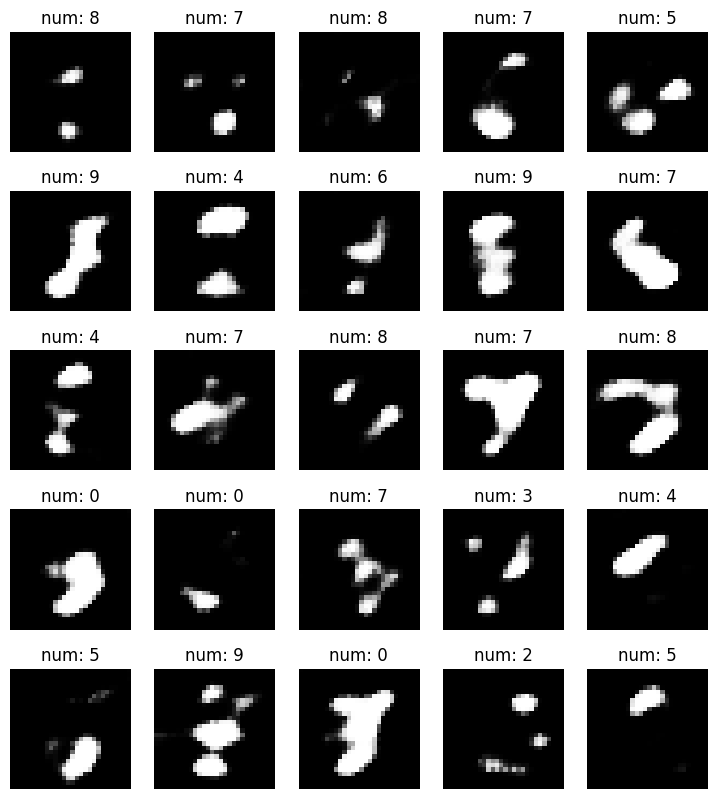

In [34]:
model = load_model('generator_1.h5')
sample_images(model, latent_dim, method='show')

1/1 [==============================] - 0s 177ms/step


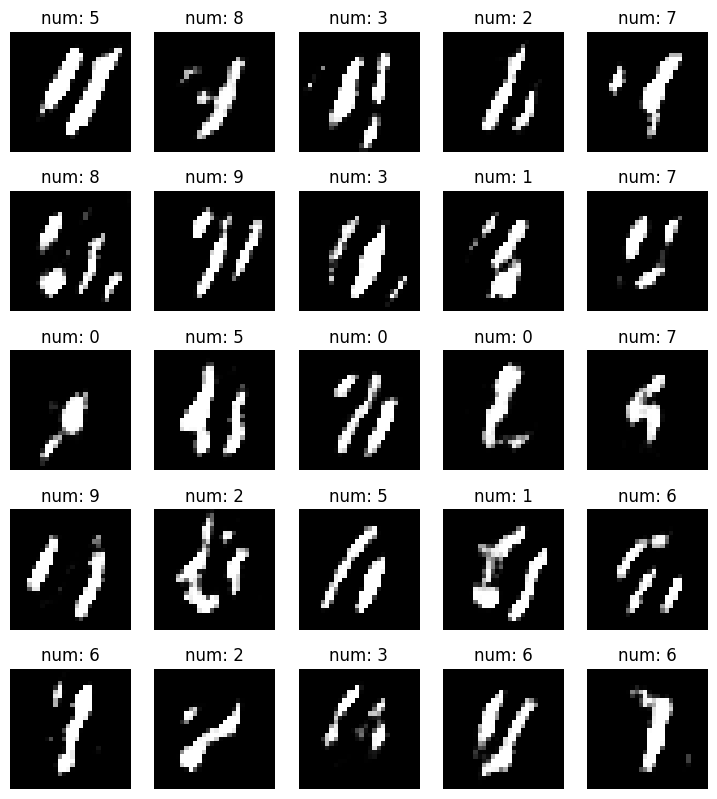

In [35]:
model = load_model('generator_4.h5')
sample_images(model, latent_dim, method='show')

1/1 [==============================] - 0s 166ms/step


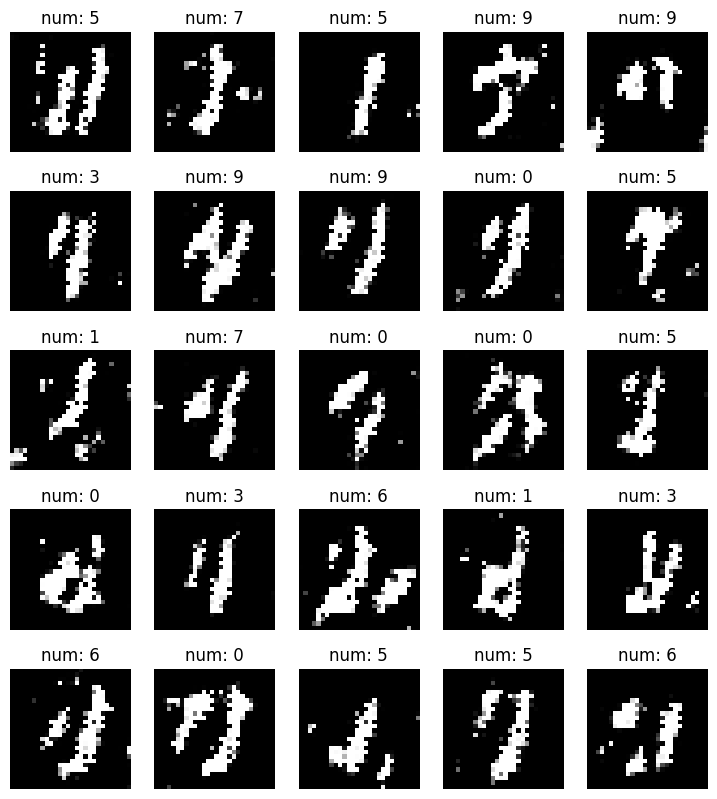

In [36]:
model = load_model('generator_7.h5')
sample_images(model, latent_dim, method='show')

1/1 [==============================] - 0s 160ms/step


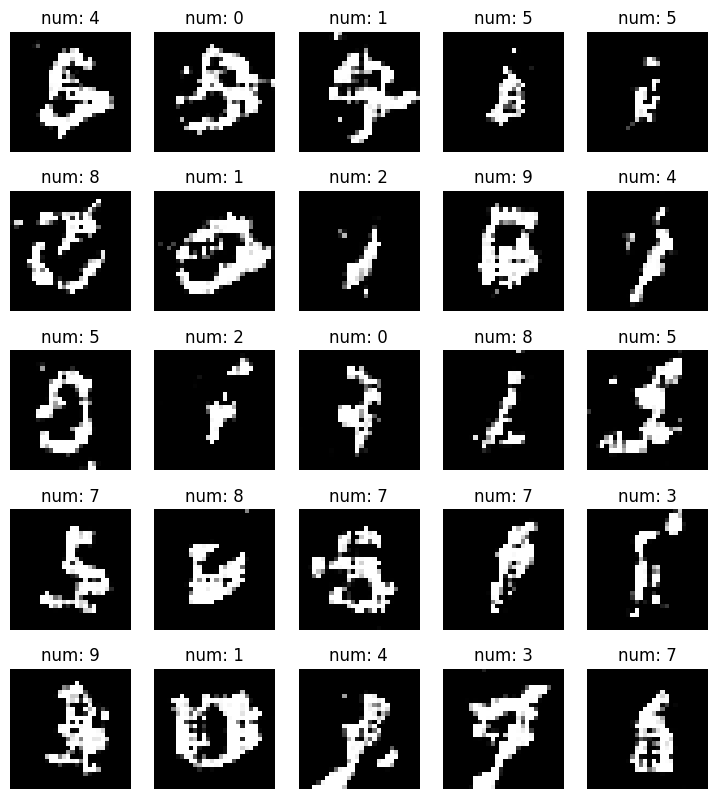

In [37]:
model = load_model('generator_10.h5')
sample_images(model, latent_dim, method='show')

1/1 [==============================] - 0s 221ms/step


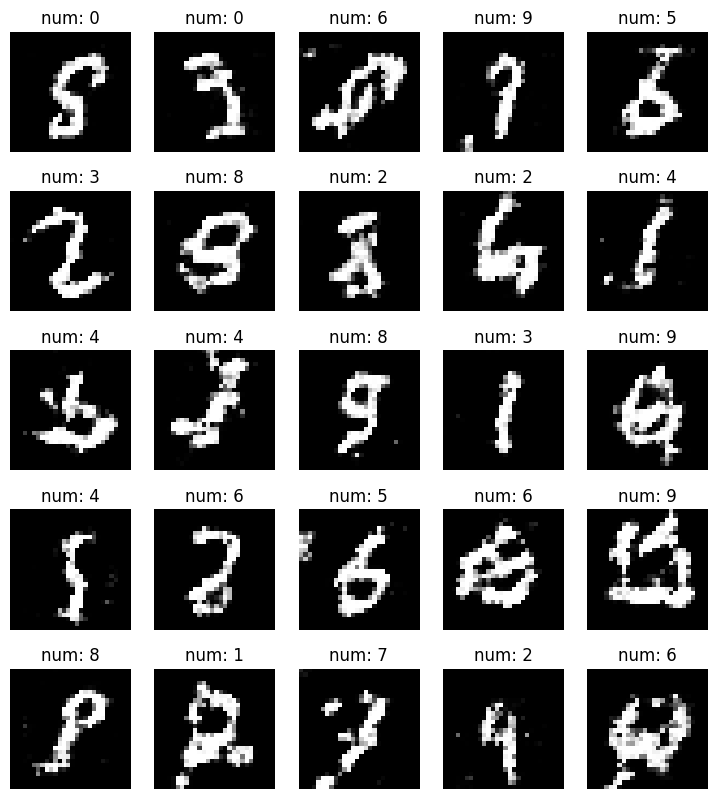

In [38]:
model = load_model('generator_13.h5')
sample_images(model, latent_dim, method='show')

1/1 [==============================] - 0s 219ms/step


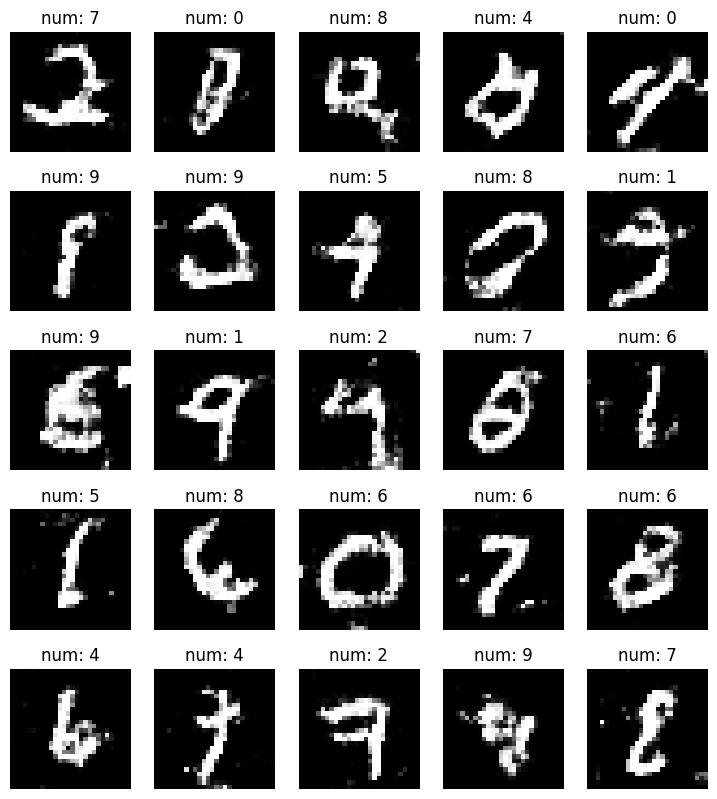

In [39]:
model = load_model('generator_16.h5')
sample_images(model, latent_dim, method='show')

Implementing evaluation metrics for the generated images

I found the following metrics:
    * inception score (https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a,
                       https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/)
    * parzen window estimation
    * conditional inception scores (Evaluation Metrics for Conditional Image Generation)
    * Frechet inception distance
    * kernel inception distance

I am implementing the conditional inception scores

In [2]:
x_example = np.ones((50, 28, 28))
y_example = np.ones((50,))

In [10]:
# we need a baseline convnet to use for calculating the inception metrics
# TODO
def load_model():

    pass

In [74]:
import numpy as np
def kl_divergence(a, b):
   '''Kullback-Leibler divergence
   Smaller value means similar distributions'''
   a, b = np.atleast_2d(np.asarray(a)), np.atleast_2d(np.asarray(b))
   eps = 1e-16
   Dkls = a * np.log((a + eps) / (b + eps))
   return Dkls.sum(axis=1)

model = load_model()

# seperately testable function calculating the metric
def _bcis(y_hat, labels):
    pG_y = np.expand_dims(y_hat.mean(axis=0), 0) # mean for all generated samples of pG_yx
    
    classes = np.unique(labels)
    Dkl = np.ndarray(len(classes))
    for i, cond in enumerate(classes):
        # mean on classes of the pG_yx values
        pG_yc = np.expand_dims(y_hat[labels == cond].mean(axis=0), 0)
        Dkl[i] = kl_divergence(pG_yc, pG_y)[0]
    return np.exp(Dkl.mean())

# pG_yx is the predicted output by the baseline model
def bcis_metric(model, inputs, labels):
    '''Between-class inception score
    Measures how close the representation of classes is to real data.
    Higher BCIS is better, it indicates the distinct class representation
    of the conditioned classes and a wide coverage across the conditional
    classes, which is desired.
    bcis = exp( Ec{ Dkl( pG_yc || pG_y ) } )'''
    inputs, labels = np.asarray(inputs), np.asarray(labels)
    y_hat = model.predict(inputs)
    return _bcis(y_hat, labels)

# seperately testable function calculating the metric
def _wcis(y_hat, labels):
    classes = np.unique(labels)
    Dkl = np.ndarray(len(classes))

    I = np.ndarray(len(classes))
    for i, cond in enumerate(classes):
        # mean of pG_yx with the given condition, as in BCIS
        pG_yc = np.expand_dims(y_hat[labels == cond].mean(axis=0), 0)
        # x is sampled from the given class
        pG_yx = y_hat[labels == cond]
        # kl divergence for each sample within the class
        Dkl = kl_divergence(pG_yx, pG_yc)
        I[i] = Dkl.mean(axis=0)
    return np.exp(I.mean())

def wcis_metric(model, inputs, labels):
    '''Within-class inception score
    Measures the quality and diversity for each of the classes.
    High WCIS indicates a wide coverage of real classes within the 
    conditioned classes, which is an undesired property.
    wcis = exp( Ec{ Dkl( pG_yx || pG_yc ) } )'''
    inputs, labels = np.asarray(inputs), np.asarray(labels)
    y_hat = model.predict(inputs)
    return _wcis(y_hat, labels)

def _inception_score(y_hat):
    pass

# calculate the inception score for p(y|x)
def inception_score_metric(p_yx, eps=1E-16):
    '''Inception score
    IS = exp( Ex{ Dkl( pG_yx || pG_y ) } )'''
    p_y = np.expand_dims(p_yx.mean(axis=0), 0)
    # kl divergence for each image
    Dkls = kl_divergence(p_yx, p_y)
    return np.exp(Dkls.mean())

In [75]:
# conditional probabilities for low quality images
p_yx = np.asarray([[0.33, 0.33, 0.33], [0.33, 0.33, 0.33], [0.33, 0.33, 0.33]])
p_yx = np.asarray([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
labels = [1, 0, 1]

score = inception_score_metric(p_yx)
wcis = _wcis(p_yx, labels)
bcis = _bcis(p_yx, labels)

print(score)
print(wcis)
print(bcis)


2.999999999999999
1.414213562373095
2.1213203435596424


In [73]:
a = np.asarray([1, 0, 0])
b = np.asarray([0.7, 0.3, 0])
kl_divergence(a, b)

array([0.35667494])